<h1 style="font-size:300%">Pokemon classification with a Support Vector Machine</h1>

BSHT Michielsen MSc

This notebook demonstrates how to use a Support Vector Machine (SVM) for image classification. Image recognition is the ability for the computer to identify an object in the image based on the visual characteristics of that object. This is a classification problem, where each possible object is a class, and the provided image should lead to 1 specific class with a as high as feasible certainty. In order to train a classification model with this, a large number of images of the same object are needed. Relative to this notebook there should be a folder named `data` in which several Pokemon images are found. These images are a subset of the [Pokemon collection by Lance Zhang](https://www.kaggle.com/datasets/lantian773030/pokemonclassification) which were picked for the fact that the selected Pokemon have strikingly different colors and therefore the machine can hopefully distinguish them fairly well. More images for the same Pokemon or even different Pokemon can be downloaded and added to the data folder.

First, the versions of the required libraries are shown. It always wise to report the versions of the libraries used so that in case problems arise in the future, one can still go back to a state in which the notebook worked.

In [21]:
import copy, pathlib, math
import PIL.Image as Image

import sklearn
import numpy
import matplotlib
import matplotlib.pyplot as plt

print("scikit-learn version:", sklearn.__version__)     # 1.1.3
print("numpy version:", numpy.__version__)              # 1.23.4
print("matplotlib version:", matplotlib.__version__)    # 3.6.2

scikit-learn version: 1.0.2
numpy version: 1.21.5
matplotlib version: 3.5.2


# 📦 Data provisioning
In real life the data provisioning phase is likely to include more steps about data sourcing and data quality, however for demo purposes in this notebook it is restricted to merely loading the images from the `data` folder, without any concern over quantity nor quality.

The code below will load the images and understand that the subfolder names are the class labels. It is important that all the images are the same size (and in this case square as well) so this code will automatically resize them. If high resolution images are available the `size` parameter can be increased and it will probably improve the performance slightly, at significantly increased training time. The given size of 256 is a middle way which is supposed to give fair results at a reasonable training time.

In [22]:
size = 256

def load_image(file, size):
    img = Image.open(file)
    img = img.resize((size, size))
    return numpy.array(img).flatten()

def load_labelled_images(path, size):
    labels = list()
    files = list()
    for file_info in [x for x in pathlib.Path(path).glob("**/**/*.jpg")]:
        labels.append(file_info.parts[1])
        files.append(str(file_info))
    imgs = numpy.array([load_image(f, size) for f in files])
    return imgs, numpy.array(labels)      

images, labels = load_labelled_images("./data", size)
print("Loaded", len(images), "images in the following", len(numpy.unique(labels)), "classes:")
for label in numpy.unique(labels):
    print(label)

Loaded 208 images in the following 6 classes:
Bulbasaur
Charmander
Electrode
Mewtwo
Pikachu
Zubat


# 📃 Sample the data
To get an impression of the data, here a sample from the loaded images is plotted so see if they we loaded correctly. The parameter `sample_size` can be increased if more images should be shown.

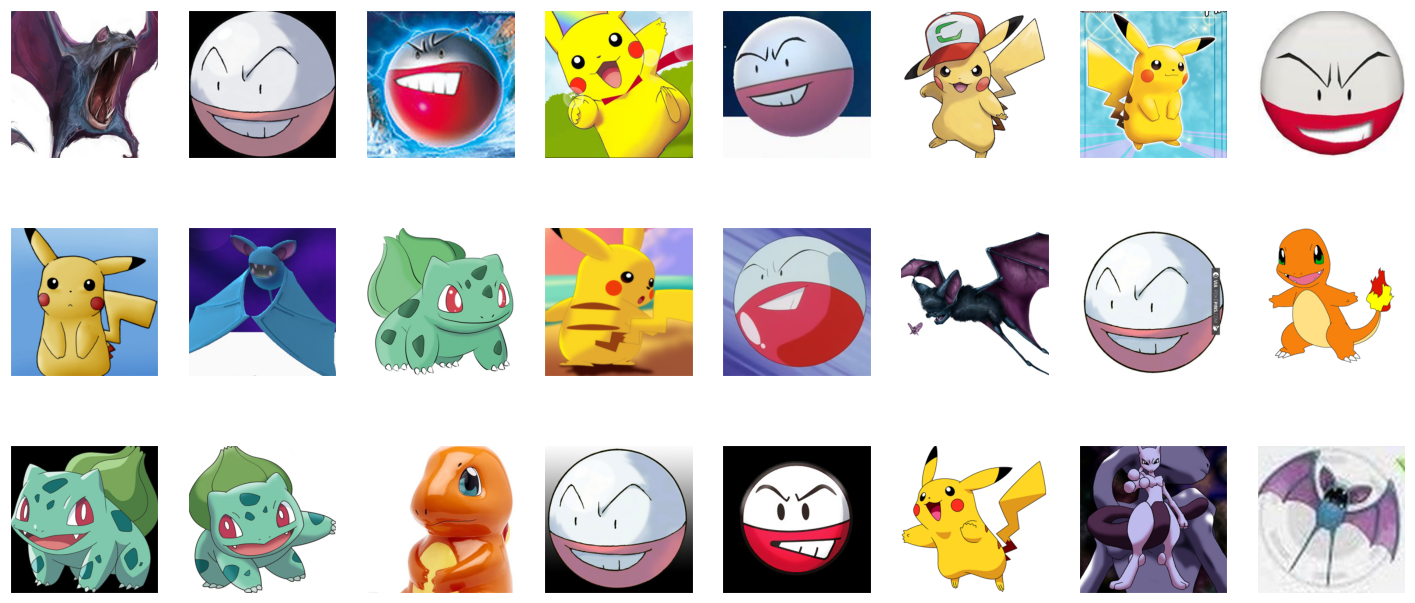

In [23]:
sample_size = 24


plotimgs = copy.deepcopy(images)
numpy.random.shuffle(plotimgs)
rows = plotimgs[:sample_size]

_, subplots = plt.subplots(nrows = math.ceil(sample_size/8), ncols = 8, figsize=(18, int(sample_size/3)))
subplots = subplots.flatten()
for i, x in enumerate(rows):
    subplots[i].imshow(numpy.reshape(x, [size, size, 3]))
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])

# 🛠️ Preprocessing
Given that this case uses images, there is no such thing as feature selection because one cannot select some pixels to be better indicators than other pixels beforehand. Therefore, there is little to do in terms of preprocessing other than splitting the dataset into a trainset and testset.

🪓 Splitting into train/test

A split of 70%/30% is chosen here in order to have a fairly large number of testing images. 

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.3, random_state=0)

# 🧬 Modelling

In this step the model will be fitted with the trainset only. In this case a [Support Vector Machine for classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [25]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.8253968253968254
Accuracy: 0.8253968253968254


# 🔬 Evaluation
Below a classification report is printed. This shows for every one of the classes how well the model performed.

In [26]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

   Bulbasaur       1.00      0.62      0.77         8
  Charmander       1.00      1.00      1.00         7
   Electrode       0.79      1.00      0.88        15
      Mewtwo       0.62      0.42      0.50        12
     Pikachu       1.00      1.00      1.00        11
       Zubat       0.69      0.90      0.78        10

    accuracy                           0.83        63
   macro avg       0.85      0.82      0.82        63
weighted avg       0.83      0.83      0.81        63



It appears that Mewtwo is fairly hard to recognize, but the others all seem well. The code below will plot every pokemon in the testset, including the predicted label as well as whether this was correct or wrong.

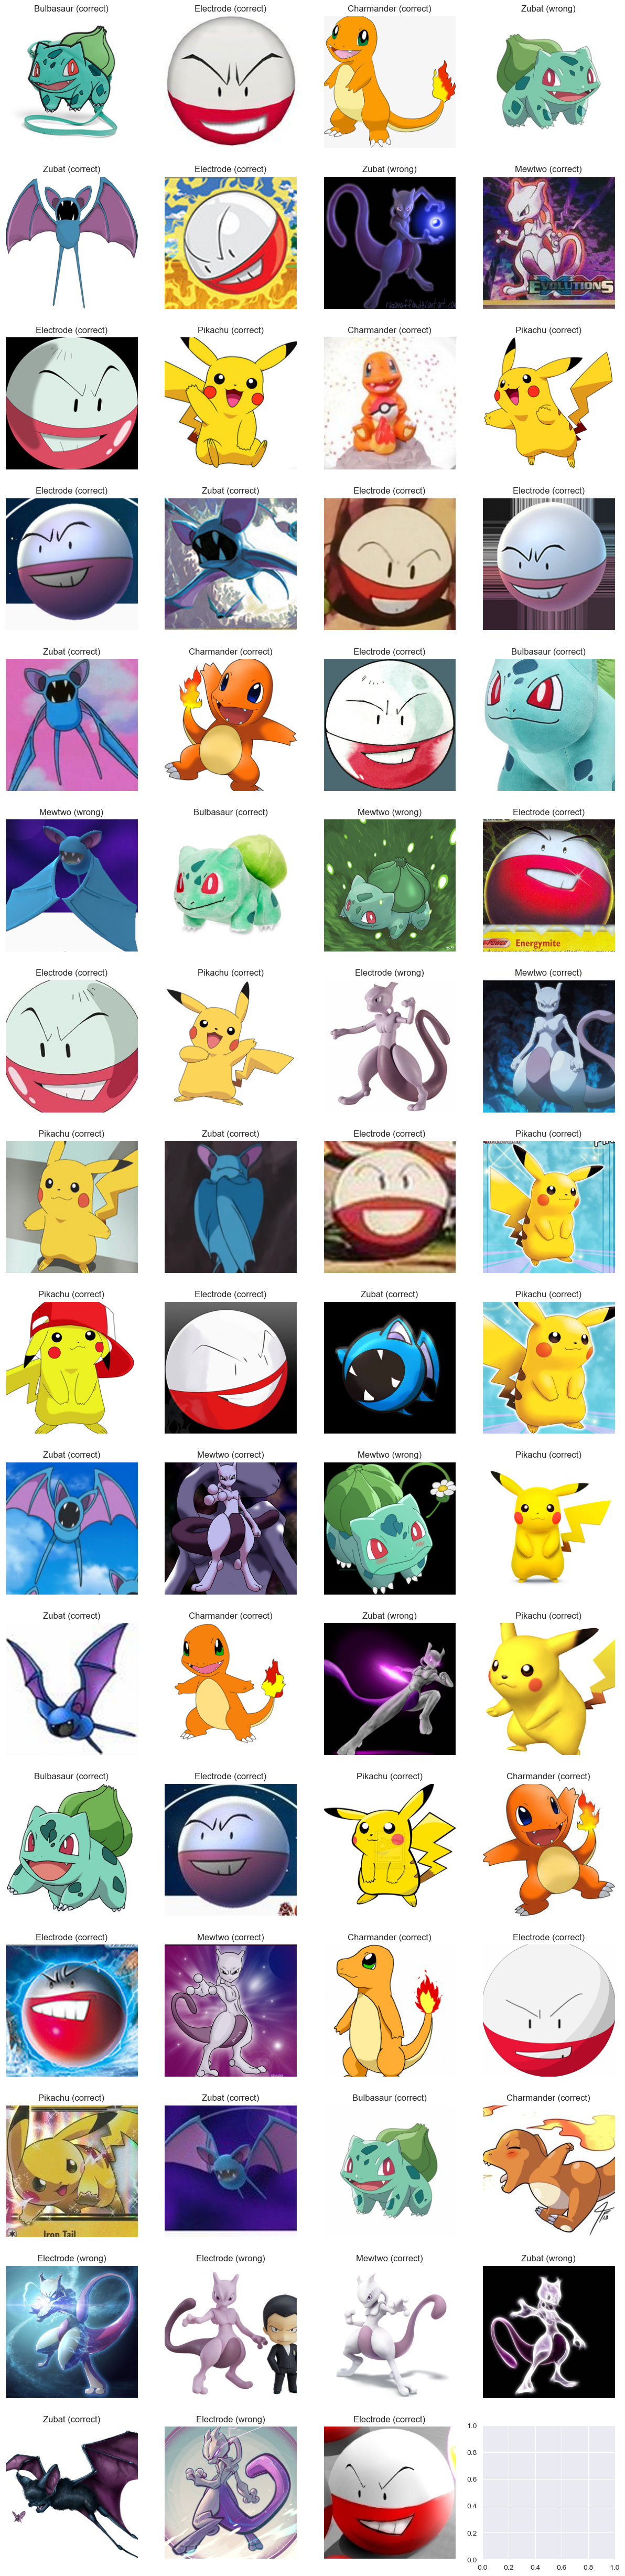

In [27]:
_, subplots = plt.subplots(nrows = math.ceil(len(X_test)/4), ncols = 4, figsize=(15, len(X_test)))
subplots = subplots.flatten()

for i, x in enumerate(X_test):
    subplots[i].imshow(numpy.reshape(x, [size, size, 3]))
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])
    subplots[i].set_title(predictions[i] + (" (correct)" if predictions[i] == y_test[i] else " (wrong)"))

Even a relatively simple Support Vector Machine with just minutes of training time can do reasonably well at image recognition. Surely a deep learning CNN would perhaps do even better, but also at largely increased need for training resources and time. Probably, when the number of Pokemon increases and others with similar colours will be added this model's quality is likely to decrease quite rappidly, but then maybe also the quality of the images should be improved to help the machine. For example, the current images are of rather poor resolution and some even have significant background noise. Having cleaner, high quality, high resolution images may improve the general outcome.

# Hyperparameter C

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.3, random_state=0)

In [54]:
from sklearn.svm import SVC
model = SVC(C=0.5)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

from sklearn.metrics import classification_report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)


Accuracy: 0.5714285714285714
              precision    recall  f1-score   support

   Bulbasaur       0.00      0.00      0.00         8
  Charmander       0.00      0.00      0.00         7
   Electrode       0.71      1.00      0.83        15
      Mewtwo       0.00      0.00      0.00        12
     Pikachu       0.61      1.00      0.76        11
       Zubat       0.42      1.00      0.59        10

    accuracy                           0.57        63
   macro avg       0.29      0.50      0.36        63
weighted avg       0.34      0.57      0.42        63



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
from sklearn.svm import SVC
model = SVC(C=1.0)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

from sklearn.metrics import classification_report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

Accuracy: 0.8253968253968254
              precision    recall  f1-score   support

   Bulbasaur       1.00      0.62      0.77         8
  Charmander       1.00      1.00      1.00         7
   Electrode       0.79      1.00      0.88        15
      Mewtwo       0.62      0.42      0.50        12
     Pikachu       1.00      1.00      1.00        11
       Zubat       0.69      0.90      0.78        10

    accuracy                           0.83        63
   macro avg       0.85      0.82      0.82        63
weighted avg       0.83      0.83      0.81        63



In [56]:
from sklearn.svm import SVC
model = SVC(C=5.0)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

from sklearn.metrics import classification_report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

Accuracy: 0.8412698412698413
              precision    recall  f1-score   support

   Bulbasaur       1.00      0.75      0.86         8
  Charmander       1.00      1.00      1.00         7
   Electrode       0.83      1.00      0.91        15
      Mewtwo       0.60      0.50      0.55        12
     Pikachu       1.00      1.00      1.00        11
       Zubat       0.73      0.80      0.76        10

    accuracy                           0.84        63
   macro avg       0.86      0.84      0.85        63
weighted avg       0.84      0.84      0.84        63



een C waarde van 1 lijkt mij het beste. Dit komt doordat deze zeer accuraat is en weinig fouten maakt. Dit is ook het geval bij een waarde van 2.0 (of hoger). Dit betekent dat een C waarde van 1.0 een goede uitkomst heeft en ook dat deze niet erg over of underfitted is.

# Hyperparameter kernel
## linear
De hyperparameter voor linear geeft zoals de naam al erg duidelijk maakt een lineaire verhouding in de data. Dit is dus een lineair model.

## poly
een polynomial kernel lijkt heel erg op een lineair model. Alleen zijn de grenslijnen niet per se recht. Dit zorgt voor een veel accurate verdeling maar houdt geen rekening met outliers.

## rbf
Een RBF kernel transformeerd de data zonder dat er iets over bekent is. Dit doet hij door er op een multi dimensionale manier naar de data te kijken en het op die manier te groeperen. Verder wordt er ook rekening gehouden met outliers.

## sigmoid
Deze kernel is gebaseerd op de sigmoid functie. Dit is een wiskundige formule en wordt gebruikt in het maken van een neuraal netwerk. Deze wordt ook gebruikt door


In [57]:
from sklearn.svm import SVC
model = SVC(kernel="linear")
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

from sklearn.metrics import classification_report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

Accuracy: 0.8412698412698413
              precision    recall  f1-score   support

   Bulbasaur       1.00      1.00      1.00         8
  Charmander       1.00      0.86      0.92         7
   Electrode       0.71      1.00      0.83        15
      Mewtwo       0.80      0.33      0.47        12
     Pikachu       0.92      1.00      0.96        11
       Zubat       0.82      0.90      0.86        10

    accuracy                           0.84        63
   macro avg       0.87      0.85      0.84        63
weighted avg       0.85      0.84      0.82        63



In [58]:
from sklearn.svm import SVC
model = SVC(kernel="poly")
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

from sklearn.metrics import classification_report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

Accuracy: 0.7936507936507936
              precision    recall  f1-score   support

   Bulbasaur       1.00      0.75      0.86         8
  Charmander       1.00      0.71      0.83         7
   Electrode       0.79      1.00      0.88        15
      Mewtwo       0.67      0.33      0.44        12
     Pikachu       0.85      1.00      0.92        11
       Zubat       0.64      0.90      0.75        10

    accuracy                           0.79        63
   macro avg       0.82      0.78      0.78        63
weighted avg       0.80      0.79      0.78        63



In [59]:
from sklearn.svm import SVC
model = SVC(kernel="sigmoid")
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

from sklearn.metrics import classification_report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

Accuracy: 0.19047619047619047
              precision    recall  f1-score   support

   Bulbasaur       0.00      0.00      0.00         8
  Charmander       0.00      0.00      0.00         7
   Electrode       0.25      0.73      0.37        15
      Mewtwo       0.00      0.00      0.00        12
     Pikachu       0.00      0.00      0.00        11
       Zubat       0.05      0.10      0.07        10

    accuracy                           0.19        63
   macro avg       0.05      0.14      0.07        63
weighted avg       0.07      0.19      0.10        63



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Bij de verschillende kernels had ik verwacht dat linear verassend goed werkte op deze data. Verder had ik de andere uitkomsten wel verwacht.

# More Pokemon


In [60]:
size = 256

def load_image(file, size):
    img = Image.open(file)
    img = img.resize((size, size))
    return numpy.array(img).flatten()

def load_labelled_images(path, size):
    labels = list()
    files = list()
    for file_info in [x for x in pathlib.Path(path).glob("**/**/*.jpg")]:
        labels.append(file_info.parts[1])
        files.append(str(file_info))
    imgs = numpy.array([load_image(f, size) for f in files])
    return imgs, numpy.array(labels)

images, labels = load_labelled_images("./data", size)
print("Loaded", len(images), "images in the following", len(numpy.unique(labels)), "classes:")
for label in numpy.unique(labels):
    print(label)

Loaded 248 images in the following 10 classes:
Ampharos
Blastoise
Bulbasaur
Charmander
Electrode
Mewtwo
Pikachu
Steelix
Tinkaton
Zubat


In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.3, random_state=0)

from sklearn.svm import SVC
model = SVC(C=1.0)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

from sklearn.metrics import classification_report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

Accuracy: 0.7066666666666667
              precision    recall  f1-score   support

    Ampharos       0.00      0.00      0.00         2
   Blastoise       0.00      0.00      0.00         4
   Bulbasaur       0.57      1.00      0.73         4
  Charmander       0.67      1.00      0.80         6
   Electrode       0.85      0.94      0.89        18
      Mewtwo       0.46      0.60      0.52        10
     Pikachu       1.00      0.83      0.91        12
     Steelix       0.00      0.00      0.00         1
    Tinkaton       0.00      0.00      0.00         5
       Zubat       0.62      0.77      0.69        13

    accuracy                           0.71        75
   macro avg       0.42      0.51      0.45        75
weighted avg       0.62      0.71      0.65        75



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Na het toevoegen van meer pokemon kom ik erachter dat het toevoegen van 10 plaatjes per pokemon te weinig is om deze voldoende te verwerken in het model. Wel is het genoeg om de accuratie van de categorisatie van andere pokemon omlaag te brengen.